[x] E01: Tune the hyperparameters of the training to beat my best validation loss of 2.2

E02: I was not careful with the intialization of the network in this video. \
[x] What is the loss you'd get if the predicted probabilities at initialization were perfectly uniform? What loss do we achieve? \
[x] Can you tune the initialization to get a starting loss that is much more similar to (1)? 

[ ] E03: Read the Bengio et al 2003 paper (link above), implement and try any idea from the paper. Did it work?

In [10]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
%matplotlib inline

In [11]:
words = open('names.txt', 'r').read().splitlines()

chars = sorted(list(set("".join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi["."] = 0
itos = {i:s for s,i in stoi.items()}

In [12]:
def build_dataset(words):
    context_len = 3
    X, Y = [], []
    
    for w in words:
        context = [0] * context_len
    
        for l in w + '.':
            ix = stoi[l]
            X.append(context)
            Y.append(ix)
            # print(''.join([itos[i] for i in context]), "->", itos[ix])
            context = context[1:] + [ix]
        
    X, Y = torch.tensor(X), torch.tensor(Y)
    # print(X.shape, Y.shape)
        
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

In [13]:
C = torch.zeros(27, 10)
W1 = torch.zeros(30, 300)
b1 = torch.zeros(300)
W2 = torch.zeros((300, 27))
b2 = torch.zeros(27)

# initializing all parameters to 0 gives you the theoretical uniform starting loss of
# ln27, ~3.295.
# We don't initialize all values uniformly in practice, as this means each neuron recieves the
# same update during backpropagation, meaning the model doesn't learn to differentiate
# between features.

In [14]:
C = torch.randn(27, 10)
W1 = torch.randn(30, 300)
b1 = torch.randn(300)
W2 = torch.randn((300, 27))
b2 = torch.randn(27)

# initializing the values to be completely random gives us a starting loss of 
# around 30 to 35. average: ~35 
# our job is to minimize this starting loss so that it is as close to the 
# theoretical minimum starting loss.

In [130]:
C = torch.randn(27, 10)
W1 = torch.randn(30, 300) * 0.01
b1 = torch.zeros(300)
W2 = torch.randn((300, 27)) * 0.01
b2 = torch.zeros(27)

# to approach this theoretical uniform loss, we first initialize biases to 0.
# this does not affect the performance of the model.
# we also initialize wights to values very close to 0. This ensures that there 
# is still variance in the initialization, but also that the total starting loss
# is close to 3.295.

In [57]:
def calculate_loss(X, Y):
    emb = C[X]
    h = torch.tanh(emb.view(emb.size(0), -1) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Y)

    return loss

mean_loss = np.mean([calculate_loss(Xtr, Ytr) for i in range(15)])
mean_loss

3.2953832

In [131]:
parameters  = [C, W1, b1, W2, b2]
steps = []
losses = []

for p in parameters:
  p.requires_grad = True

sum(p.nelement() for p in parameters)

17697

In [132]:
# decay functions

def step_decay(i, s1, s2):
    lr = 0.1 if i < s1 else (0.01 if i < s2 else 0.001)
    return lr

def exp_decay(i, lr0=0.1, k=1e-5):
    lr = lr0 * (0.99 ** i)
    return lr

def inverse_root_decay(i, lr0=0.1, t0=10000):
    lr = lr0 / ((1 + (i / t0)) ** 0.5)
    return lr

In [133]:
num_iter = 50000
for i in range(num_iter):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32,))
    
    # forward pass
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(emb.size(0), -1) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    # lr = step_decay(i, 20000, 40000)
    # lr = exp_decay(i)
    lr = inverse_root_decay(i, 0.1, 10000)
    for p in parameters:
        p.data += -lr * p.grad

    steps.append(i)
    losses.append(loss.log10().item())

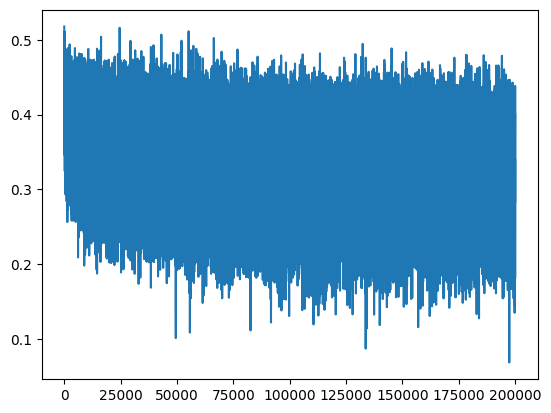

In [134]:
plt.plot(steps, losses)

In [135]:
def calculate_loss(X, Y):
    emb = C[X]
    h = torch.tanh(emb.view(emb.size(0), -1) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Y)

    return loss

loss_tr = calculate_loss(Xtr, Ytr)
loss_val = calculate_loss(Xdev, Ydev)
loss_te = calculate_loss(Xte, Yte)

print(f"Training loss: {loss_tr}\nValidation loss: {loss_val}\nTest loss: {loss_te}")

Training loss: 2.098369598388672
Validation loss: 2.1389002799987793
Test loss: 2.1436970233917236


**Step Decay 50K iters**:\
Training loss: 2.186199426651001\
Validation loss: 2.197913408279419\
Test loss: 2.1986262798309326

**Exponential Decay 50K iters (k = 1e-7)**:\
Training loss: 2.7215478134155273\
Validation loss: 2.7373971843719482\
Test loss: 2.7314894008636475

**Inverse Square Root 50K iters (lr0 = 0.1, t0 = 10000)**:\
Training loss: 2.1848747730255127\
Validation loss: 2.1972532272338867\
Test loss: 2.19810152053833

#### Thus, We choose inverse square root loss.

**t0 = 50K, 50K iters**:
- Training loss: 2.178662061691284
- Validation loss: 2.2019031047821045
- Test loss: 2.198951482772827

**t0 = 20K, 50K iters**:
- Training loss: 2.181793212890625
- Validation loss: 2.198199987411499
- Test loss: 2.1938960552215576
 
**t0 = 20K, 200K iters**:
- Training loss: 2.098369598388672
- Validation loss: 2.1389002799987793
- Test loss: 2.1436970233917236

**t0 = 10K, 200K iters**:
- Training loss: 2.1009891033172607
- Validation loss: 2.137007474899292
- Test loss: 2.136446714401245

#### Final Choice: Inverse Square Root (lr0 = 0.1, t0 = 10K)